In [7]:
import pandas as pd
import numpy as np
import datetime
import random

# ------------------ STORM CELL GENERATION (Corrected for Data Generation) ------------------
def generate_storm_cell_lifecycle(
    cell_id,
    start_date,
    end_date,
    time_step_minutes=5,
    movement_randomness_scale=0.2
):
    """
    Generates a single storm cell's lifecycle with all requested properties.
    The lifetime calculation is now consistent with Scenario 1's logic.
    """
    records = []

    time_range_seconds = (end_date - start_date).total_seconds()
    formation_time = start_date + datetime.timedelta(seconds=random.uniform(0, time_range_seconds))

    target_peak_intensity_dbz = np.random.normal(40, 10)
    target_peak_intensity_dbz = max(10, min(70, target_peak_intensity_dbz))
    
    # --- CHANGE: Lifetime from Normal Distribution with min/max bounds (Scenario 1 Logic) ---
    mean_lifetime_hours = 40 / 60  # ~40 minutes
    std_dev_lifetime_hours = 0.3
    min_lifetime_hours = 15 / 60   # 15 minutes
    max_lifetime_hours = 1.5       # 1.5 hours
    
    lifetime_hours = np.random.normal(mean_lifetime_hours, std_dev_lifetime_hours)
    lifetime_hours = max(min_lifetime_hours, min(max_lifetime_hours, lifetime_hours))
    # --- END CHANGE ---

    lifetime_delta = datetime.timedelta(hours=lifetime_hours)
    dissipation_time = formation_time + lifetime_delta

    base_vx = np.random.normal(0, 2.0)
    base_vy = np.random.normal(0, 2.0)
    x_position, y_position = 0, 0

    previous_intensity = 0
    current_time = formation_time
    
    # max_rainfall and total_rainfall_sum are no longer needed
    
    while current_time <= dissipation_time:
        time_elapsed_seconds = (current_time - formation_time).total_seconds()
        progress = time_elapsed_seconds / 3600
        
        # --- Intensity calculation remains unchanged from original Scenario 3 logic ---
        if lifetime_hours == 0:
            intensity_dbz = 0.0
        else:
            growth_phase_hours = lifetime_hours * 0.5
            decay_phase_hours = lifetime_hours * 0.5
            if progress < growth_phase_hours:
                scaled_progress = progress / growth_phase_hours
                intensity_dbz = target_peak_intensity_dbz / (1 + np.exp(-10 * (scaled_progress - 0.5)))
            else:
                decay_progress = (progress - growth_phase_hours) / decay_phase_hours
                intensity_dbz = target_peak_intensity_dbz * np.exp(-10 * decay_progress)

        intensity_dbz = max(0.0, intensity_dbz + np.random.normal(0, 0.5))
        
        intensity_change_rate = (intensity_dbz - previous_intensity) / (time_step_minutes / 60)
        size_pixels = 20 + (intensity_dbz / target_peak_intensity_dbz) * 120 if target_peak_intensity_dbz > 0 else 20
        size_pixels = size_pixels * random.uniform(0.9, 1.1)
        
        base_rainfall = 0.08 * (intensity_dbz ** 1.5)
        rainfall_factor = 1.0 + random.uniform(-0.1, 0.1)
        rainfall_mmhr = base_rainfall * rainfall_factor
        rainfall_mmhr = max(0.0, rainfall_mmhr)
        
        # No longer tracking max_rainfall or total_rainfall_sum here

        vx = base_vx + np.random.normal(0, movement_randomness_scale)
        vy = base_vy + np.random.normal(0, movement_randomness_scale)
        x_position += vx * (time_step_minutes / 60)
        y_position += vy * (time_step_minutes / 60)

        records.append({
            'cell_id': cell_id,
            'timestamp_utc': current_time,
            'formation_time_utc': formation_time,
            'dissipation_time_utc': dissipation_time,
            'lifetime_hours': lifetime_hours,
            'time_since_formation_hours': progress,
            'x_position': x_position,
            'y_position': y_position,
            'size_pixels': max(0, int(size_pixels)),
            'intensity_dbz': intensity_dbz,
            'rainfall_mm_per_hr': rainfall_mmhr,
            'intensity_change_rate': intensity_change_rate,
        })
        previous_intensity = intensity_dbz
        current_time += datetime.timedelta(minutes=time_step_minutes)

    # Now returns only the records
    return records

# ------------------ RUN SIMULATION (Main Loop) ------------------
print("--- Generating storms with unique intensity profiles and persistent direction ---")

all_storm_data = []
num_simulated_cells = 50000
overall_start_date = datetime.datetime(2024, 8, 1, 0, 0, 0)
overall_end_date = datetime.datetime(2024, 8, 5, 23, 59, 59)

for i in range(num_simulated_cells):
    # No longer collecting peak_rainfall or total_rainfall
    cell_records = generate_storm_cell_lifecycle(
        cell_id=f'StormCell_{i+1:05d}',
        start_date=overall_start_date,
        end_date=overall_end_date
    )
    all_storm_data.extend(cell_records)

# Create DataFrame directly from the collected records
final_df = pd.DataFrame(all_storm_data)
final_df = final_df.sort_values(by=['cell_id', 'timestamp_utc']).reset_index(drop=True)

output_file = "scenario3_variable_50000.csv"
final_df.to_csv(output_file, index=False, date_format='%Y-%m-%d %H:%M:%S.%f')

print(f"Generated {len(final_df)} rows for {num_simulated_cells} storms → saved to {output_file}.")
print(f"File contains the following columns: {', '.join(final_df.columns)}")

--- Generating storms with unique intensity profiles and persistent direction ---
Generated 433021 rows for 50000 storms → saved to scenario3_variable_50000.csv.
File contains the following columns: cell_id, timestamp_utc, formation_time_utc, dissipation_time_utc, lifetime_hours, time_since_formation_hours, x_position, y_position, size_pixels, intensity_dbz, rainfall_mm_per_hr, intensity_change_rate


In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# -------------------- Load and Inspect Data --------------------
# This script assumes the CSV file is in the same directory.
# If you get a FileNotFoundError, please ensure the file is in the same directory as this script.
file_path = "scenario3_variable_50000.csv"
try:
    storm_df = pd.read_csv(file_path)
    print("Data loaded successfully.")
except FileNotFoundError:
    print(f"Error: The file '{file_path}' was not found. Please ensure the file is in the correct directory.")
    # Exit the script gracefully if the file is not found
    exit()

# Convert relevant columns to appropriate data types
storm_df['timestamp_utc'] = pd.to_datetime(storm_df['timestamp_utc'])
storm_df['formation_time_utc'] = pd.to_datetime(storm_df['formation_time_utc'])
storm_df['dissipation_time_utc'] = pd.to_datetime(storm_df['dissipation_time_utc'])

# -------------------- 1. Verify Variable Lifetime --------------------
print("\n--- Verifying Variable Lifetime Distribution ---")
# Get a single lifetime value for each storm cell
lifetimes = storm_df.groupby('cell_id')['lifetime_hours'].first()

print("Descriptive Statistics for Storm Lifetimes:")
print(lifetimes.describe())

# -------------------- 2. Verify Variable Peak Intensity --------------------
print("\n--- Verifying Variable Peak Intensity Distribution ---")
# Group by storm cell and find the maximum intensity for each
peak_intensities = storm_df.groupby('cell_id')['intensity_dbz'].max()

print("Descriptive Statistics for Peak Intensities:")
print(peak_intensities.describe())

# -------------------- 3. Verify Variable Movement Direction --------------------
print("\n--- Verifying Variable Movement Direction ---")
# Get the final position (last record) for each storm
final_positions = storm_df.drop_duplicates(subset=['cell_id'], keep='last').set_index('cell_id')

# Calculate the start-to-end vector for each storm
# Since all storms start at (0,0), the final position IS the vector
x_vectors = final_positions['x_position']
y_vectors = final_positions['y_position']

print("Descriptive Statistics for Final X Positions:")
print(x_vectors.describe())
print("\nDescriptive Statistics for Final Y Positions:")
print(y_vectors.describe())

# Visualize the final positions to see the spread of movement
plt.figure(figsize=(8, 8))
# Plot a random sample of 1000 storms for clarity
sample_size = min(1000, len(final_positions))
sampled_vectors = final_positions.sample(sample_size)
plt.scatter(sampled_vectors['x_position'], sampled_vectors['y_position'], alpha=0.3, s=10)
plt.title(f'Final Position of {sample_size} Storms (Origin at 0,0)')
plt.xlabel('Final X Position (arbitrary units)')
plt.ylabel('Final Y Position (arbitrary units)')
plt.axhline(0, color='gray', linestyle='--', linewidth=0.8)
plt.axvline(0, color='gray', linestyle='--', linewidth=0.8)
plt.grid(True)
plt.gca().set_aspect('equal', adjustable='box')
plt.savefig('storm_movement_scatter.png')
plt.close()

print("\nVisualization of storm movement saved to 'storm_movement_scatter.png'.")

Data loaded successfully.

--- Verifying Variable Lifetime Distribution ---
Descriptive Statistics for Storm Lifetimes:
count    50000.000000
mean         0.676336
std          0.276722
min          0.250000
25%          0.463686
50%          0.665629
75%          0.866798
max          1.500000
Name: lifetime_hours, dtype: float64

--- Verifying Variable Peak Intensity Distribution ---
Descriptive Statistics for Peak Intensities:
count    50000.000000
mean        37.912939
std          9.913996
min          5.974960
25%         31.065670
50%         37.805029
75%         44.638421
max         70.465252
Name: intensity_dbz, dtype: float64

--- Verifying Variable Movement Direction ---
Descriptive Statistics for Final X Positions:
count    50000.000000
mean        -0.004385
std          1.549944
min         -8.655907
25%         -0.873316
50%         -0.004965
75%          0.868354
max         10.520285
Name: x_position, dtype: float64

Descriptive Statistics for Final Y Positions:
count

In [10]:
import pandas as pd
import matplotlib.pyplot as plt

# ------------------ LOAD THE SIMULATED DATA ------------------
csv_file = "scenario3_variable_50000.csv"
storm_df = pd.read_csv(csv_file, parse_dates=['timestamp_utc', 'formation_time_utc', 'dissipation_time_utc'])

# -------------------- 3. Visualize Two Storm Lifecycles --------------------
print("\n--- Visualizing Two Unique Storms with Different Peak Intensities ---")

# Get the storm with the highest and lowest peak intensity to highlight the difference
min_peak_storm_id = peak_intensities.idxmin()
max_peak_storm_id = peak_intensities.idxmax()

# Filter the data for these two storms
low_intensity_storm_df = storm_df[storm_df['cell_id'] == min_peak_storm_id]
high_intensity_storm_df = storm_df[storm_df['cell_id'] == max_peak_storm_id]

# Create a figure with a 2x1 grid of subplots
fig, axes = plt.subplots(2, 1, figsize=(12, 10), sharex=True)
fig.suptitle('Comparison of Storms with Different Peak Intensities and different Lifetime)', fontsize=16)

# Plot Intensity vs. Lifetime
axes[0].plot(low_intensity_storm_df['time_since_formation_hours'], low_intensity_storm_df['intensity_dbz'], label=f'Low Intensity Storm (Peak: {low_intensity_storm_df["intensity_dbz"].max():.2f} dBZ)')
axes[0].plot(high_intensity_storm_df['time_since_formation_hours'], high_intensity_storm_df['intensity_dbz'], label=f'High Intensity Storm (Peak: {high_intensity_storm_df["intensity_dbz"].max():.2f} dBZ)')
axes[0].set_title('Intensity vs. Time Since Formation')
axes[0].set_xlabel('Time Since Formation (hours)')
axes[0].set_ylabel('Intensity (dBZ)')
axes[0].legend()
axes[0].grid(True)
axes[0].set_xlim(0, 1.5) # Set x-axis limit to show the fixed lifetime

# Plot Rainfall vs. Lifetime
axes[1].plot(low_intensity_storm_df['time_since_formation_hours'], low_intensity_storm_df['rainfall_mm_per_hr'], label=f'Low Intensity Storm')
axes[1].plot(high_intensity_storm_df['time_since_formation_hours'], high_intensity_storm_df['rainfall_mm_per_hr'], label=f'High Intensity Storm')
axes[1].set_title('Rainfall vs. Time Since Formation')
axes[1].set_xlabel('Time Since Formation (hours)')
axes[1].set_ylabel('Rainfall (mm/hr)')
axes[1].legend()
axes[1].grid(True)
axes[1].set_xlim(0, 1.5)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig('storm_lifecycle_comparison.png')
plt.close()

print("\nVisualization saved to 'storm_lifecycle_comparison.png'.")



--- Visualizing Two Unique Storms with Different Peak Intensities ---

Visualization saved to 'storm_lifecycle_comparison.png'.


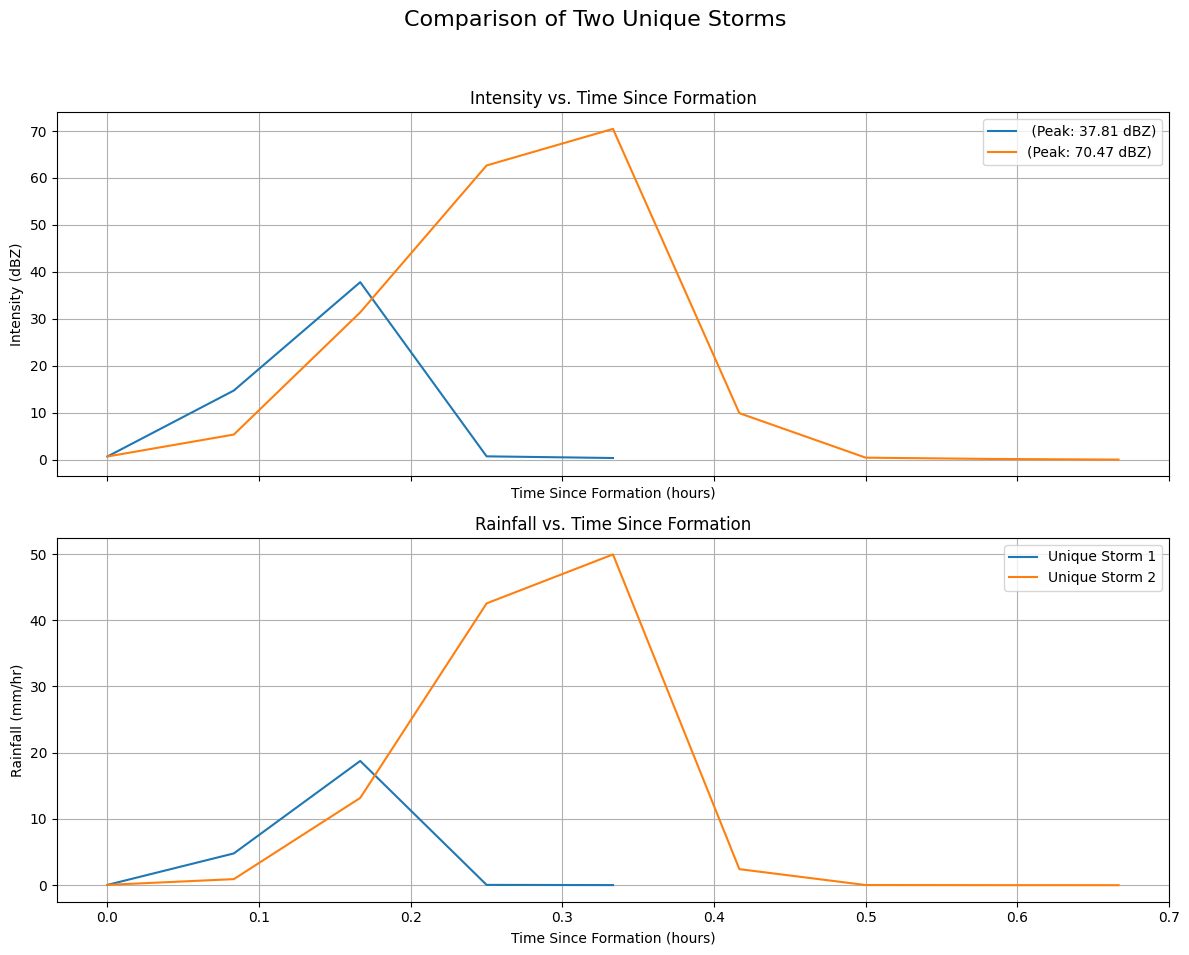


Visualization saved to 'storm_lifecycle_comparison_median.png'.


In [4]:
import pandas as pd
import matplotlib.pyplot as plt

# ------------------ LOAD THE SIMULATED DATA ------------------
csv_file = "scenario3_variable_50000.csv"
storm_df = pd.read_csv(csv_file, parse_dates=['timestamp_utc', 'formation_time_utc', 'dissipation_time_utc'])

# ------------------ IDENTIFY PEAK INTENSITIES ------------------
# Compute the peak intensity for each storm
peak_intensities = storm_df.groupby('cell_id')['intensity_dbz'].max()

# Get the storm with the median and highest peak intensity
median_peak_storm_id = peak_intensities.sort_values().iloc[len(peak_intensities)//2]
median_peak_storm_id = peak_intensities[peak_intensities == median_peak_storm_id].index[0]
max_peak_storm_id = peak_intensities.idxmax()

# Filter data for the two unique storms
median_intensity_storm_df = storm_df[storm_df['cell_id'] == median_peak_storm_id]
high_intensity_storm_df = storm_df[storm_df['cell_id'] == max_peak_storm_id]

# ------------------ VISUALIZATION ------------------
fig, axes = plt.subplots(2, 1, figsize=(12, 10), sharex=True)
fig.suptitle('Comparison of Two Unique Storms', fontsize=16)

# Plot Intensity vs. Time Since Formation
axes[0].plot(median_intensity_storm_df['time_since_formation_hours'], 
             median_intensity_storm_df['intensity_dbz'], 
             label=f' (Peak: {median_intensity_storm_df["intensity_dbz"].max():.2f} dBZ)')
axes[0].plot(high_intensity_storm_df['time_since_formation_hours'], 
             high_intensity_storm_df['intensity_dbz'], 
             label=f'(Peak: {high_intensity_storm_df["intensity_dbz"].max():.2f} dBZ)')
axes[0].set_title('Intensity vs. Time Since Formation')
axes[0].set_xlabel('Time Since Formation (hours)')
axes[0].set_ylabel('Intensity (dBZ)')
axes[0].legend()
axes[0].grid(True)

# Plot Rainfall vs. Time Since Formation
axes[1].plot(median_intensity_storm_df['time_since_formation_hours'], 
             median_intensity_storm_df['rainfall_mm_per_hr'], label='Unique Storm 1')
axes[1].plot(high_intensity_storm_df['time_since_formation_hours'], 
             high_intensity_storm_df['rainfall_mm_per_hr'], label='Unique Storm 2')
axes[1].set_title('Rainfall vs. Time Since Formation')
axes[1].set_xlabel('Time Since Formation (hours)')
axes[1].set_ylabel('Rainfall (mm/hr)')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig('storm_lifecycle_comparison_median.png')
plt.show()

print("\nVisualization saved to 'storm_lifecycle_comparison_median.png'.")